# Exercise 4 - Integration of liquid water transport

This script is an extension of the script elaborated in Exercise 3 of *Advanced Numerical Methods 1*. The base script was capable of  calculating the temperature and moisture field across a multi-layered building component, while considering water transport induced by vapor diffusion. Such a multi-layered building component is shown in {numref}`fig:multilayCompEx2`.

```{figure} ./Figures/BuildingComponent.png
---
width: 350px
name: fig:multilayCompEx2
---
Multi-layered building component and discretisation requirements [excersise Description]
```

To show the effect of liquid water transport the implementation will be tested by reproducing a suction expirement described in {cite}`kalagasidis2004`. To simplify the problem, the component is restricted to a constant grid size. Therefore for each cell P $\Delta x_P = \Delta x_W = \Delta x_E = \Delta x_p = \Delta x_w = \Delta x_e = \Delta x$

## Balance Equations

To consider the latent heat effect the time derivative of the Temperaturefield seen in {eq}`heatflow` is expandend by the moisture induced pressure field.  The equation for heat conduction including latent heat is shown in {eq}`gl:heatmoist2`:
 
$$\rho \cdot c \cdot \frac{dT}{dt} = \nabla (\lambda \nabla T + L_v \delta_v \nabla p_{vap}) $$ (gl:heatmoist2)

The introduced moisture field extended by the transport induced by liquide vapor pressure. {eq}`gl:moist`:

$$ \frac{dw}{dt} =  \nabla (\delta_v \nabla p_{vap}) - \nabla (K_w \nabla p_{vap}) $$ (gl:moist)

With the total moisture conductivity $K_w$ according to {cite}`kalagasidis2004` (specialized for $u_f = 300$):

$$ K_w(P_{suc,n)} = - \frac{\partial w(P_{suc})}{\partial P_{suc}} \cdot  \frac{n+1}{2n} (\frac{A}{300})^n (\frac{w(P_{suc})}{300})^n(n+1-(\frac{w(P_{suc})}{300})^n )$$ (gl:K_w)

and the corresponding water retention curve:

$$ w(P_{suc)} = - \frac{300}{1+P_{suc} \cdot 10^{-6}}$$ (gl:P_suc)

## Space discretisation

The discretisation of {eq}gl:heatmoist and {eq}gl:moist is done similar to section {ref}`Exercise 1 <sec:Ex1>` using the finite volume method and a representation as RC-Networks.  Evaluating for a cell P surrounded by a cell to the east and west results in {eq}`gl:heatmoistdis` and {eq}`gl:moistdis`:

$$\rho \cdot c \cdot \frac{T^{n+1}_P - T^n_P  }{\Delta t} = \frac{\lambda_w(T^n_E - T^n_P) - \lambda_w(T^n_P - T^n_W)}{\Delta x^2} + L_v \cdot \frac{\delta_{v,w}(p_{vap,E}^n - p_{vap,P}^n) - \delta_{v,e}(p_{vap,P}^n - p_{vap,W}^n)}{\Delta x^2}  $$ (gl:heatmoistdis)

$$\frac{w_{P}^{n+1} - w_{P}^n }{\Delta t} =\frac{\delta_{v,w}(p_{vap,E}^n - p_{vap,P}^n) - \delta_{v,e}(p_{vap,P}^n - p_{vap,W}^n)}{\Delta x^2} \textcolor{green}{- \frac{K_{w}(p_{suc,E}^n - p_{suc,P}^n) - K_{e}(p_{suc,P}^n - p_{suc,W}^n)}{\Delta x^2}} $$ (gl:moistdis)

or written in matrix notation:

$$\rho \cdot c \cdot \frac{T^{n+1} - T^n  }{\Delta t} = \lambda  \cdot K \cdot T + L_v \cdot \delta_v  \cdot M \cdot p_{vap} $$ (gl:heatmoistdis)
$$\frac{w^{n+1} - w^n  }{\Delta t} = \delta_v  \cdot M \cdot p_{vap} \textcolor{green}{ - K_w \cdot p_{suc}} $$ (gl:moistdis)

The thermal and vapor diffusive conductivity matrices are calculated by harmonic averaging. The thermal conductivity between two cells (W,P) can be described as follows:

$$ \lambda_{w} = \frac{\Delta x_w}{\frac{\Delta x_W}{2 \cdot \lambda_W} + \frac{\Delta x_P}{2 \cdot \lambda_P}} = \frac{1}{\frac{1}{2 \cdot \lambda_W} + \frac{1}{2 \cdot \lambda_P}}$$

As eleborated in {cite}`kalagasidis2004` harmoic averaging is not a suitable averaging method for liquid water transport. Therefore, in this implementation linear averaging will be used. The total moisture conductivity between two cells (W,P) can be described as follows:

$$ K_{w} = \frac{K_{W}\frac{\Delta x_W}{2} }{x_w} + \frac{K_{P}\frac{\Delta x_P}{2} }{x_w} = \frac{K_W+K_P}{2}$$

To ensure surface drying is prevented the vapor diffusion coefficient on the surface is set $\delta_v = 0\ m/s$  {cite}`kalagasidis2004`.

## Time Integration

The integration will be achieved by the use of a solver from the **scipy** library. It is to be mentioned, that due to high gradients in the water retention curve implicit solvers are to be preferred.

## Implementation

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import copy as copy
from scipy import integrate
import matplotlib.animation as animation

### Object definition

In [2]:
class layer:
    # n summarizes the number of all cells
    # start value for n = number of boundaries, makes place for boundary temp
    n=2
    # width sumarizes the thickness of all layers
    width_sum =0

    def __init__(self, material, width, n_cells, thermConduct, heatCap, density):
        self.material = material
        self.width = width
        self.n_cells = n_cells
        self.thermConduct = thermConduct
        self.heatCap = heatCap
        self.density = density

        # Adding number of cells and width to class counters
        layer.n += self.n_cells
        layer.width_sum += self.width

In [3]:
class boundary:
    def __init__(self, temperature1, temperature2, resistance1, resistance2,humidity1, humidity2,  humresistance1, humresistance2):
        self.temperature1 = temperature1
        self.temperature2 = temperature2
        self.resistance1 = resistance1
        self.resistance2 = resistance2
        self.humidity1 = humidity1
        self.humidity2 = humidity2
        self.humresistance1 = humresistance1
        self.humresistance2 = humresistance2

### Construction of the layer and boundary objects
Input Values according to the excersise description with the following units:
* [$\lambda$]= $W\ m^{-2}\ K^{-1}$
* [$R_s$]= $W^{-1}\ m^{2}\ K$
* [$T$]= $^\circ C$
* [$t$]= $m$
* [$c$]= $J\ kg^{-1} K^{-1}$
* [$\rho$]= $kg\ m^{-3}$
* [$A$]= $kg\ m^{-2}s^{-1}$
* [$K_w$]= $s$


In [4]:
boundaries = boundary(20,20,0.13,0.13,99.9,0.01, 1/(3e-8), 1/(3e-8))

#Beware, each layer must have at least 3 cells!
layers = []
layers.append(layer("Dämmung", 0.1, 100, 0.04, 1000, 160))

### Sorption Isotherm

In [5]:
def fc_w_phi(phi):
    a=300
    b=250*1e-3
    c=1
    res= a/np.power(1-np.log(phi/100)/b,1/c)
    return res 

In [6]:
def fc_phi_w(w):
    a=300
    b=250e-3
    c=1
    phi= np.exp(b*(1-(a/w)**c)) * 100 
    return phi 

In [7]:
a=[]

for i in range(1,100):
    a.append(fc_w_phi(i))

Text(0.5, 1.0, 'Sorption Isotherm - mineral wool')

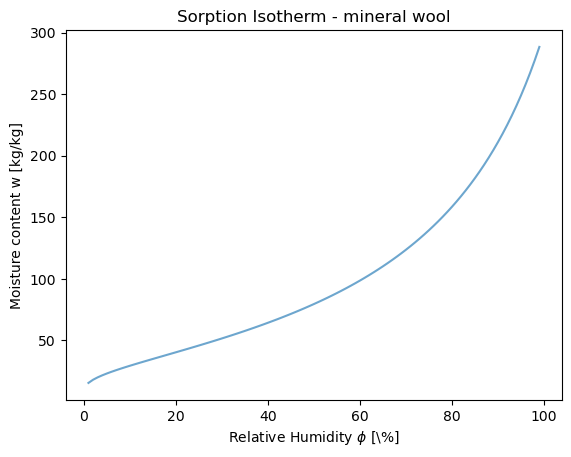

In [8]:
plt.xlabel("Relative Humidity $\phi$ [\%]")
plt.ylabel("Moisture content w [kg/kg]")

plt.plot(range(1,100,1), a,  alpha=0.65)
plt.title("Sorption Isotherm - mineral wool")

### Water permability, saturated vapor pressure and heat conductivity

In [9]:
def fc_psat_T (T):
    #    return 610.5 * np.exp( 17.269*T / (237.3+T)) # T>0
    #    return 610.5 * np.exp( 21.875*T / (265.5+T)) # T<0
    #return np.power(10, 7.625*T/(241+T)+2.7877) # Lehrbuch
    return 0.61094 * np.exp(17.625* T / (T + 243.03))

In [10]:
def fc_deltapv_T (w,T):
    a= (22.2 + 0.14*T) * 10**-6
    b= -a 
    return (a + b*w /1000) *1e-2 /2

In [11]:
def fc_lambda_w (w):
    return 0.04 + 6*w /1000

In [12]:
def update_Cm(w,phi,T):
	epsilon=0.001*np.min(w)
	wp=w+epsilon
	phip=fc_phi_w(wp)
	dw=abs(wp-w)
	dphi=abs(phip-phi)/100
	pvs=fc_psat_T(T)
	Cm=dw/dphi/pvs
	return Cm

In [13]:
Lv = 2503000

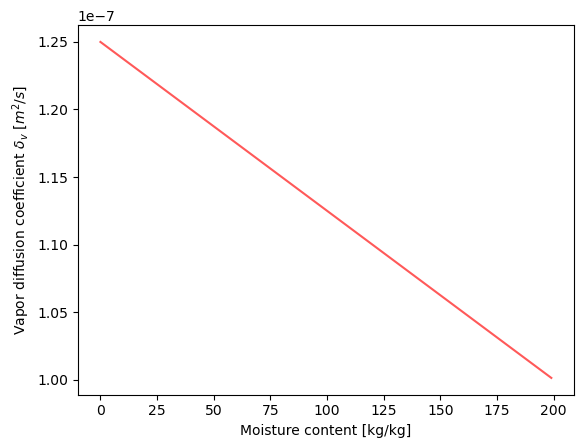

In [14]:
b = fc_deltapv_T(np.array(np.arange(0,200,1)),np.ones(len(np.array(np.arange(0,200,1)))) * 20)

plt.ylabel("Vapor diffusion coefficient $\delta_v$ [$m^2/s$]")
plt.xlabel("Moisture content [kg/kg]")

plt.plot(np.arange(0,200,1), b, alpha=0.65, color="red")



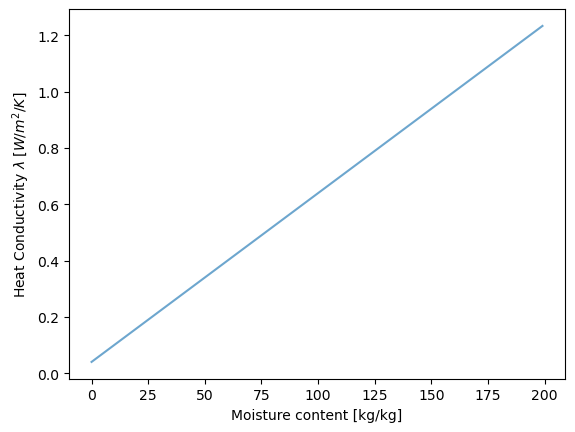

In [15]:
b = fc_lambda_w(np.arange(0,200,1))

plt.ylabel("Heat Conductivity $\lambda$ [$W/m^2/K$]")
plt.xlabel("Moisture content [kg/kg]")

plt.plot(np.arange(0,200,1), b, alpha=0.65)

### Liquid Water transport

In [16]:
#function which resembles the suction curve
def fc_wsuc_psuc(psuc):
    return  300/ (1 + psuc * 1e-6)

In [17]:
#inverse of the suction curve
def fc_psuc_w(w):
    return (300/w - 1 ) * 1e6

In [18]:
#calculating the total moisture conductivity
def fc_Kw_psuc_wsuc_n(w,n):
    psuc = fc_psuc_w(w)
    wsuc = w
    dwsuc = - 3e8 /(psuc + 1e6)**2
    return -dwsuc * (n+1)/(2*n) * (10/60/300)**2 * (wsuc/300)**n * (n+1-(wsuc/300)**n)

In [19]:
#Array to plot suction curve
a=np.array([])
for i in range(1,299):
    a = np.append(a,fc_psuc_w(np.array([i])))
    
b= np.array([])

#Loop to produce an expentionaly spaced water contant array
for i in range(0,100,1):
    b = np.append(b,np.exp(i*0.2))

#Test inverse of suction curve
c= np.array([])
for i in b:
    c = np.append(c,fc_wsuc_psuc(i))

#Array to Plot the total moisture conductivity Kw
h=fc_wsuc_psuc(b)
d=np.array([])
for i in h:
    d = np.append(d,fc_Kw_psuc_wsuc_n(np.array([i]),13))

Text(0.5, 1.0, 'Total moisture conductivity $K_w$')

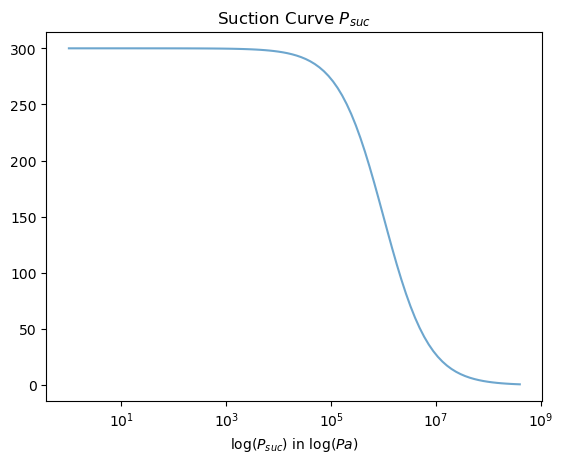

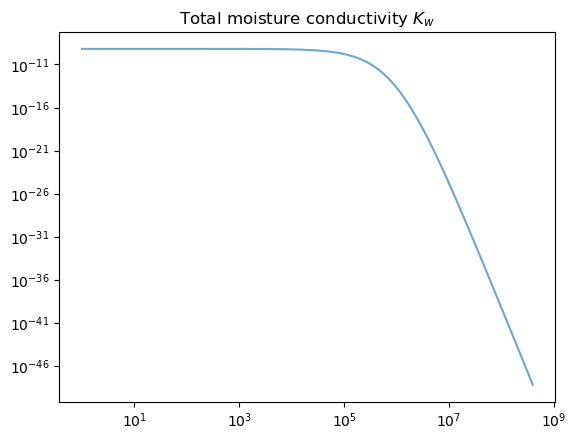

In [20]:
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# line, = ax.plot(a,range(1,299,1),  alpha=0.65)
# ax.set_xscale("log")
# plt.title("Sorption Isotherm - mineral wool")

fig2 = plt.figure()
bx = fig2.add_subplot(1,1,1)
lin2, = bx.plot(b,c,alpha=0.65)
bx.set_xscale("log")
plt.title("Suction Curve $P_{suc}$")
plt.xlabel("$\log( P_{suc})$ in $\log(Pa)$")

fig3 = plt.figure()

cx = fig3.add_subplot(1,1,1)
lin3, =cx.plot(b,d,alpha=0.65)
cx.set_xscale("log")
cx.set_yscale("log")
plt.title("Total moisture conductivity $K_w$")

### Conductivity Matrices

In [21]:
def new_Cmatrix_norm_avg(Kw,layers):
    # reference number of cells to increase readability
    n = layers[-1].n
    
    # Initialising conductivity matrix K and M
    W = np.zeros((n,n))
    
    # iterater to keep track of cell numbers
    counter = 1
    for layer in layers:
        #step size for the current layer
        deltaX=layer.width / layer.n_cells
        
        #initialize empty conductivity matrix for the current layer
        W_current = np.zeros((n,n))
        
        for cell in range(0,layer.n_cells):
        
        
            #defining the "east" and "west" conductivity for interior cells
            W_current[counter,counter-1]= 1/2 / deltaX **2 *(Kw[counter-1] + Kw[counter])
            W_current[counter,counter+1]= 1/2 / deltaX **2 *(Kw[counter] + Kw[counter+1])
            
            counter += 1
    W += W_current
    
    #The diagonal of the conductivity matrix is defined as the negative sum of the 
    #"east" and "west" conductivity for the cell
    W[range(0,len(W)),range(0,len(W))]= -np.sum(W,axis=1)
    
    #free first and last row; this leads to constant values at the boundaries
    W[0,:]=0
    W[-1,:]=0

    W[-2,-2]=W[-2,-2]/2
    W[-2,-1]=0
    W[1,0]=W[1,0]/2

    return W

In [22]:
def new_Cmatrix_harm_avg(Kw,layers):
    # reference number of cells to increase readability
    n = layers[-1].n
    
    # Initialising conductivity matrix K and M
    W = np.zeros((n,n))
    
    # iterater to keep track of cell numbers
    counter = 1
    for layer in layers:
        #step size for the current layer
        deltaX=layer.width / layer.n_cells
        
        #initialize empty conductivity matrix for the current layer
        W_current = np.zeros((n,n))
        
        for cell in range(0,layer.n_cells):
        
        
            #defining the "east" and "west" conductivity for interior cells
            W_current[counter,counter-1]= 1 / deltaX **2 * 2/(1/Kw[counter-1] + 1/Kw[counter])
            W_current[counter,counter+1]= 1 / deltaX **2 * 2/(1/Kw[counter] + 1/Kw[counter+1])
                    
            counter += 1
    W += W_current
    
    #The diagonal of the conductivity matrix is defined as the negative sum of the 
    #"east" and "west" conductivity for the cell
    W[range(0,len(W)),range(0,len(W))]= -np.sum(W,axis=1)
    
    #free first and last row; this leads to constant values at the boundaries
    W[0,:]=0
    W[-1,:]=0

    W[-2,-1]=0
    W[1,0]=W[1,0]/2

    return W

### Construction of the conductivity matrix $K$ and $M$

### Initialize Temperature and Moisture Field

In [23]:
#initialize the temperaturefield
vec_T_w = np.ones(layer.n*2) * 0.001
vec_T_w[0:layer.n-1] = 20
vec_T_w[layer.n:layer.n*2] = fc_w_phi(0.01)

#Insert Boundary Konditions
vec_T_w[0]= boundaries.temperature1
vec_T_w[layer.n-1]= boundaries.temperature2
#Insert Boundary Konditions
vec_T_w[layer.n]= 300
vec_T_w[-1]= 0.001
#print(vec_T_w)


### Solving

In [24]:
def dt_w_dt(t,vec_T_w):
    #Splitting up temp and water vector
    
    T = vec_T_w[0:layer.n]
    w = vec_T_w[layer.n:layer.n*2]
    result.append(w)


    
    c = 1000
    rho = 160
    Lv = 2503000
    
    
    thermConduct = fc_lambda_w(w)
    deltapv = fc_deltapv_T(w,T)

    #vapor pressure
    phi = fc_phi_w(w)
    pvap = fc_psat_T(T) * phi /100
    M = new_Cmatrix_harm_avg(deltapv,layers)
  
    
    #liquid water transport
    psuc = fc_psuc_w(w)
    Kleit = fc_Kw_psuc_wsuc_n(w,13)
    W = new_Cmatrix_norm_avg(Kleit,layers)

    K = new_Cmatrix_harm_avg(thermConduct,layers)

    
    delta_T = ( np.dot(K,T) +  deltapv * Lv * np.dot(M,pvap) )/(c*rho)

    
    liquittransport = - np.dot(W,psuc)
    vaportransport = np.dot(M,pvap)
    delta_w =  liquittransport + vaportransport

    testarray.append(vaportransport[20])
    testarray2.append(liquittransport[20])
   
    
    return np.append(delta_T,delta_w)

In [25]:
testarray=[]
testarray2=[]
result = []

#dt_w_dt(t,vec_T_w)
result_coupled_fluid = scipy.integrate.solve_ivp(dt_w_dt,(0,60*60*24*3),vec_T_w,method="Radau")#,atol=1e-10,rtol=1e-8)

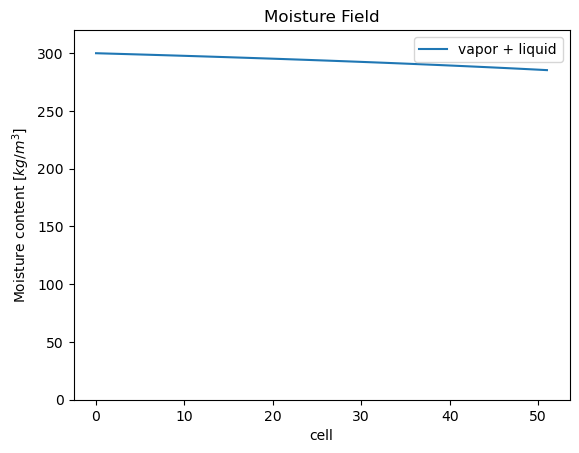

In [41]:
res_w_heat =[]
res_w_coup=[]
for i in range(layer.n,layer.n*2):
    res_w_coup.append(result_coupled_fluid.y[i,-1])
    res_w_heat.append(0)
    
plt.ylabel("Moisture content [$kg/m^3$]")
plt.xlabel("cell")
plt.ylim([0,320])

plt.title("Moisture Field")

plt.plot(np.linspace(0,layer.n /2), res_w_coup[0:round(layer.n/2)-1], label="vapor + liquid")
plt.legend()

In [27]:
#reduce the result to allow an animation
redresult= []
for i in range(len(result)):
    if i%1000 == 0:
        redresult.append(result[i])

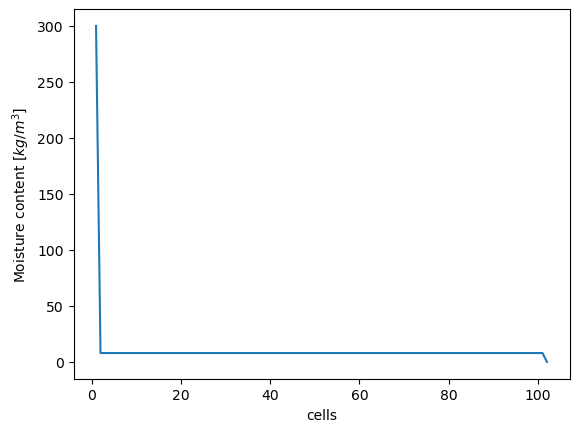

In [32]:
cells = np.linspace(1,layer.n,layer.n)

t = np.linspace(1,len(redresult),len(redresult))

fig, ax = plt.subplots()
l, = ax.plot(cells,redresult[0])
    
plt.ylabel("Moisture content [$kg/m^3$]")
plt.xlabel("cells")


def animate(i):
    l.set_data(cells, redresult[i])

ani = animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_html5_video())